In [98]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import sys
# sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')
import os
device_mappings = {0: 1, 1: 5, 2: 6, 3: 7, 4: 2, 5: 3, 6: 0, 1: 4}
os.environ["CUDA_VISIBLE_DEVICES"] = str(device_mappings[2])

import random
import string
from collections import defaultdict, OrderedDict
from itertools import product, chain
import math
import numpy as np
import logging
import types

from pattern.en import comparative
import matplotlib.pyplot as plt
import seaborn as sns

# from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
# from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [100]:
import transformers
transformers.__version__

'4.18.0.dev0'

In [101]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from enum import Enum
from typing import List, Optional, Union
# from transformers import RobertaForMaskedLM


from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
from transformers import AutoConfig, PreTrainedModel, RobertaForMaskedLM, RobertaTokenizer
# from transformers.modeling_roberta import RobertaForProbing, RobertaDoubleHeadsModel, \
#     RobertaDoubleHeadsModel2, RobertaDoubleHeadsModel3, RobertaForSequenceClassification  # XD
# from transformers.trainer import get_mean_pred_prob  # XD
from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM, GPTJForCausalLM, XGLMForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForCausalLM

logging.basicConfig(level=logging.ERROR)

In [102]:
from common_utils import *
from utils import *
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [92]:
model_name = "gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
model = GPT2LMHeadModel.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
models[model_name] = model, tokenizer

In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/vocab.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/merges.txt
In cached_path: output_path = /nas/xd/.cache/torch/transformers/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/added_tokens.json
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/special_tokens_map.json
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/tokenizer_config.json
In cached_path: url_or_filename = https://huggingface.co/gpt2/resolve/main/config.json
In cached_path: output_path = /nas/xd/.cache/torch/transformers/

In [93]:
_=model.eval()

In [94]:
 import random
 input_ids = random.sample(range(200,20000),25)
 input_ids = torch.tensor(input_ids).view(1,25)
 input_ids.shape
 input_ids

torch.Size([1, 25])

tensor([[19802,   946,   826,  6043,  6367, 15828,   701,  5467,  3019, 11292,
          9149,  6382,  9079, 11681,  5262,  4677,  3304,  5835,  2137,  3103,
         11477, 19640,  5682, 13647, 18493]])

In [111]:
from dataclasses import dataclass

@dataclass
class Outputs:
    inputs_embeds: torch.FloatTensor = None
    position_embeds: torch.FloatTensor = None
    attn_outputs: tuple = ()
    intermediates: tuple = ()
    mlp_outputs: tuple = ()
    hidden_states: tuple = ()
    attentions: tuple = ()
    logits: torch.FloatTensor = None
    all_attn_withoutO: tuple = ()
    all_W_O: tuple = ()

In [121]:
# forward function for gpt-xl
def forwardxl(model, input_ids):
    input_shape = input_ids.size()
    device = input_ids.device
    position_ids = torch.arange(0, input_shape[-1], dtype=torch.long, device=device)
    position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])
    self = model.transformer
    inputs_embeds = self.wte(input_ids)
    position_embeds = self.wpe(position_ids)
    hidden_states = inputs_embeds + position_embeds
    hidden_states = self.drop(hidden_states)
    attn_outputs, intermediates, mlp_outputs = (), (), ()
    all_hidden_states, all_attentions = (), ()
    all_attn_withoutO = ()
    all_W_O = ()
    for i, b in enumerate(self.h):
        all_hidden_states += (hidden_states,)
        attn_output, _, attention, attn_withoutO = b.attn(b.ln_1(hidden_states),output_attentions=True)
        W_O = b.attn.c_proj.weight.view(20, 64, 1280)
        # print((W_O.view(1280,1280)-b.attn.c_proj.weight).abs().mean())
        all_W_O += (W_O,)
        all_attn_withoutO += (attn_withoutO,)
        attn_outputs += (attn_output,)
        all_attentions += (attention,)
        hidden_states = hidden_states + attn_output
        mlp_output = b.mlp(b.ln_2(hidden_states))
        # intermediates += (intermediate,)
        mlp_outputs += (mlp_output,)
        hidden_states = hidden_states + mlp_output
    all_hidden_states += (hidden_states,) # both before and after ln_f
    hidden_states = self.ln_f(hidden_states)
    all_hidden_states += (hidden_states,)
    logits = model.lm_head(hidden_states)
    return Outputs(
        inputs_embeds=inputs_embeds, position_embeds=position_embeds,
        attn_outputs=attn_outputs, intermediates=intermediates, mlp_outputs=mlp_outputs,
        hidden_states=all_hidden_states, attentions=all_attentions, logits=logits, all_attn_withoutO = all_attn_withoutO, all_W_O = all_W_O,
    )

In [122]:
with torch.no_grad(): o = forwardxl(model, input_ids)

In [124]:
(o.all_W_O[0].shape)

torch.Size([20, 64, 1280])

In [138]:
expand_input_ids = input_ids.repeat(1,20,1)
expand_input_ids.shape

torch.Size([1, 20, 25])

In [169]:
aaa = torch.rand(2,4)
aaa
index = torch.ones(2).long()
# index[0]
aaa[:,index]

tensor([[0.6354, 0.9089, 0.0625, 0.5538],
        [0.2815, 0.0303, 0.6752, 0.9601]])

tensor([[0.9089, 0.9089],
        [0.0303, 0.0303]])

In [165]:
#位置编码矩阵？W_0的bias
# hidden states要改变。
#位置编码也要加
copyhead=[]
for i in range(36):
    copyheadOnelayer=[]
    attn_withoutO = o.all_attn_withoutO[i]# torch.Size([1, 20, 25, 64])
    W_O = o.all_W_O[i] # torch.Size([20, 64, 1280])
    # W_O_bias= o.attn.c_proj.bias #最终要不要加bias
    attention_output = torch.einsum('mijk,ikl->mijl',[attn_withoutO, W_O]) #[1,20,25,1280]
    logits = model.lm_head(attention_output)#不加残差流，这里有问题
    bias = torch.zeros((25, 50257), dtype=torch.uint8)#设置mask机制
    for k in range(25):
        bias[k:,input_ids[0][k]] = 1 
    causal_mask = bias.bool().unsqueeze(0).repeat(1,20,1,1)#[1,20,25,50527]
    logits=torch.where(causal_mask, logits, torch.tensor(-1e9))
    loggailv=nn.functional.softmax(logits, dim=-1)#算出加上mask logits [1,20,25,50527]
    attention_max=torch.max(o.attentions[i],dim=-1) #[1,20,25,25]
    # print(attention_max.indices.view(1*20*25))#torch.Size([1, 20, 25])
    attention_indices = input_ids[0,attention_max.indices.view(1*20*25)]
    attention_indices = attention_indices.view(1,20,25)
   
    jieguo= torch.zeros(25,1)
    for k in range(25):
        jieguo[k][0]=loggailv[0,k,tmp[k]]
    # print(jieguo.mean())
    copyheadOnelayer.append(jieguo.mean().detach().numpy().tolist())
    copyhead.append(copyheadOnelayer[:])
        
        
        

    


torch.Size([500])
tensor([[19802,   946,   826,  6043,  6367, 15828,   701,  5467,  3019, 11292,
          9149,  6382,  9079, 11681,  5262,  4677,  3304,  5835,  2137,  3103,
         11477, 19640,  5682, 13647, 18493]])


In [ ]:
torch.nn.CrossEntropyLoss

In [97]:
# position_ids = torch.arange(0, input_shape[-1], dtype=torch.long, device=device)
# position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])
self = model.transformer
inputs_embeds = self.wte(input_ids) #位置编码要不要加？
# position_embeds = self.wpe(position_ids)
# hidden_states = inputs_embeds + position_embeds
# hidden_states = self.drop(hidden_states)
hidden_states =inputs_embeds
attn_output, _, attention ,aaa = self.h[0].attn(self.h[0].ln_1(hidden_states),output_attentions=True) #1, 25, 1280]
W_O = self.h[0].attn.c_proj.weight.split(64,0)
bias= self.h[0].attn.c_proj.bias #最终要不要加bias
aaa.shape
attention.shape

torch.Size([1, 20, 25, 64])

torch.Size([1, 20, 25, 25])

In [ ]:
ans= torch.zeros(1,25,1280)
for i in range(20):
    ans+=aaa[:,i,:,:].matmul(W_O[i])
ans += bias
(ans-attn_output).abs().mean()#验证计算是否正确。

In [ ]:
ans= torch.zeros(1,25,1280)
ans+=aaa[:,0,:,:].matmul(W_O[0]) #要不要加bias 【1，25，64】*【64，1280】
# ans.shape
logits = model.lm_head(ans) #1,25,50527


In [ ]:
input_ids
logits.shape

In [ ]:
bias = torch.zeros((25, 50257), dtype=torch.uint8)#设置mask机制

for i in range(25):
    bias[i:,input_ids[0][i]] = 1 

In [ ]:
causal_mask = bias.bool().unsqueeze(0)
# causal_mask.shape
# logits.shape
logits=torch.where(causal_mask, logits, torch.tensor(-1e9))
loggailv=nn.functional.softmax(logits, dim=-1)


In [ ]:
attention[0,0,:,:].shape

In [ ]:
ssss=torch.max(attention[0,0,:,:],dim=-1)
ssss ##自身关注自身算不算copy head ，需要把这种情况去掉吗

In [ ]:
input_ids.shape
tmp=input_ids[0,ssss.indices]
tmp
# loggailv[0,:,input_ids[0,ssss.indices]]
# # loggailv.sum(dim=-1).shape

# loggailv[0,0,tmp[i]]

jieguo= torch.zeros(25,1)
for i in range(25):
    jieguo[i][0]=loggailv[0,i,tmp[i]]


jieguo


In [141]:
#位置编码矩阵？W_0的bias
# hidden states要改变。
#位置编码也要加
copyhead=[]
for i, b in enumerate(self.h):
    copyheadOnelayer=[]
    attn_output, _, attention, attn_withoutO = b.attn(b.ln_1(hidden_states),output_attentions=True)  #torch.Size([1, 25, 1280]) torch.Size([1, 20, 25, 25]) torch.Size([1, 20, 25, 64])
    W_O = b.attn.c_proj.weight.split(64,0)
    W_O_bias= b.attn.c_proj.bias #最终要不要加bias
    
    for j in range(attention.size()[1]):
        ans= torch.zeros(1,25,1280)
        ans+=attn_withoutO[:,j,:,:].matmul(W_O[j]) #要不要加bias 【1，25，64】*【64，1280】
    # ans.shape
        logits = model.lm_head(ans)#不加残差流，这里有问题
        bias = torch.zeros((25, 50257), dtype=torch.uint8)#设置mask机制
        for k in range(25):
            bias[k:,input_ids[0][k]] = 1 
        causal_mask = bias.bool().unsqueeze(0)
        logits=torch.where(causal_mask, logits, torch.tensor(-1e9))
        loggailv=nn.functional.softmax(logits, dim=-1)#算出加上mask logits
        ssss=torch.max(attention[0,j,:,:],dim=-1)
        print(ssss.indices.shape)
        break
    break
        # tmp=input_ids[0,ssss.indices]
        # jieguo= torch.zeros(25,1)
        # for k in range(25):
        #     jieguo[k][0]=loggailv[0,k,tmp[k]]
        # # print(jieguo.mean())
        # copyheadOnelayer.append(jieguo.mean().detach().numpy().tolist())
    copyhead.append(copyheadOnelayer[:])
        
        
        

    


torch.Size([25])


In [ ]:
copyhead[20]

In [ ]:
copyhead[20]

In [ ]:
input_ids_mul4=input_ids.repeat(1,4)

In [ ]:
input_ids_mul4


In [ ]:
prefix_head=[]#cumcum
hidden_states_mul4 = self.wte(input_ids_mul4)
for i, b in enumerate(self.h):
    prefix_headOnelayer=[]
    attn_output, _, attention, attn_withoutO = b.attn(b.ln_1(hidden_states_mul4),output_attentions=True)  #torch.Size([1, 100, 1280]) torch.Size([1, 20, 100, 100]) torch.Size([1, 20, 100, 64])
    for j in range(attention.size()[1]):

        bias = torch.zeros((100, 100), dtype=torch.uint8)#设置mask机制
        for k in range(25,100):#第24个忽略不计 ABCD ABCD 前4个都不算吧
             tmp = k
             while tmp >=0:
                tmp -= 25
                bias[k,tmp+1] = 1 
        causal_mask = bias.bool().unsqueeze(0)
        logits=torch.where(causal_mask, attention[0,j,:,:], torch.tensor(0).float())

        logits=logits.sum(-1).mean()
        # print(logits)
        # break
    # break
        # loggailv=nn.functional.softmax(logits, dim=-1)#算出加上mask logits
        # ssss=torch.max(attention[0,j,:,:],dim=-1)
        # tmp=input_ids[0,ssss.indices]
        # jieguo= torch.zeros(25,1)
        # for k in range(25):
        #     jieguo[k][0]=loggailv[0,k,tmp[k]]
        # print(jieguo.mean())
        prefix_headOnelayer.append(logits.detach().numpy().tolist())
    prefix_head.append(prefix_headOnelayer[:])

In [71]:
prefix_head[35]

[0.01204527635127306,
 0.0381932407617569,
 0.029538216069340706,
 0.001129591022618115,
 0.04770129173994064,
 0.010484611615538597,
 0.017978686839342117,
 0.02985200099647045,
 0.024105070158839226,
 0.030567592009902,
 0.05426609143614769,
 0.028371388092637062,
 0.01278347335755825,
 0.018284093588590622,
 0.010165493935346603,
 0.0025588818825781345,
 0.02210092730820179,
 0.027966342866420746,
 0.01568540185689926,
 0.05994144454598427]

In [76]:
import matplotlib.pyplot as plt
import numpy as np
copyhead11= np.array(copyhead).reshape(36*20)
prefix_head11 = np.array(prefix_head).reshape(36*20)
copyhead.shape
# prefix_head.shape


(36, 20)

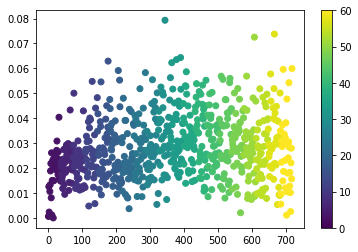

In [75]:
color=0
tmp=np.zeros(36*20)
for i in range(36*20):
    tmp[i]=color
    if i%36==0:
        color+=3
plt.scatter(range(36*20),prefix_head11,c=tmp,cmap='viridis')
plt.colorbar()
plt.show()

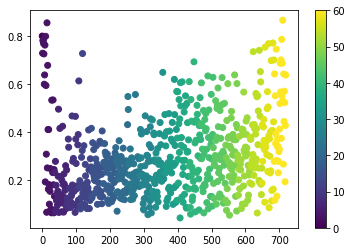

In [77]:
plt.scatter(range(36*20),copyhead11,c=tmp,cmap='viridis')
plt.colorbar()
plt.show()